🔄 Generating synthetic regression data...
🚀 Running optimization experiments...
   Traditional Gradient Descent...
   Beam Search Gradient Descent...
GRADIENT DESCENT COMPARISON RESULTS

📊 FINAL METRICS:
Metric                    Traditional GD  Beam Search GD  Winner    
----------------------------------------------------------------------
Training Loss             0.015277        0.009776        Beam      
Validation Loss           0.016806        0.010593        Beam      
Param Distance            0.070620        0.011388        Beam      
Iterations                200             200             Traditional

🎯 PARAMETER RECOVERY:
True weights:        [-0.42375968 -0.45341411 -1.79564317 -0.33009019  0.73282908 -1.27423212]
Traditional final:   [-0.43583745 -0.48477922 -1.7485286  -0.34400638  0.74146993 -1.23722661]
Beam search final:   [-0.42943001 -0.45116575 -1.7989635  -0.33148547  0.74173665 -1.27463629]

🚀 IMPROVEMENT SUMMARY:
Training loss improvement: +36.01%
Validation l

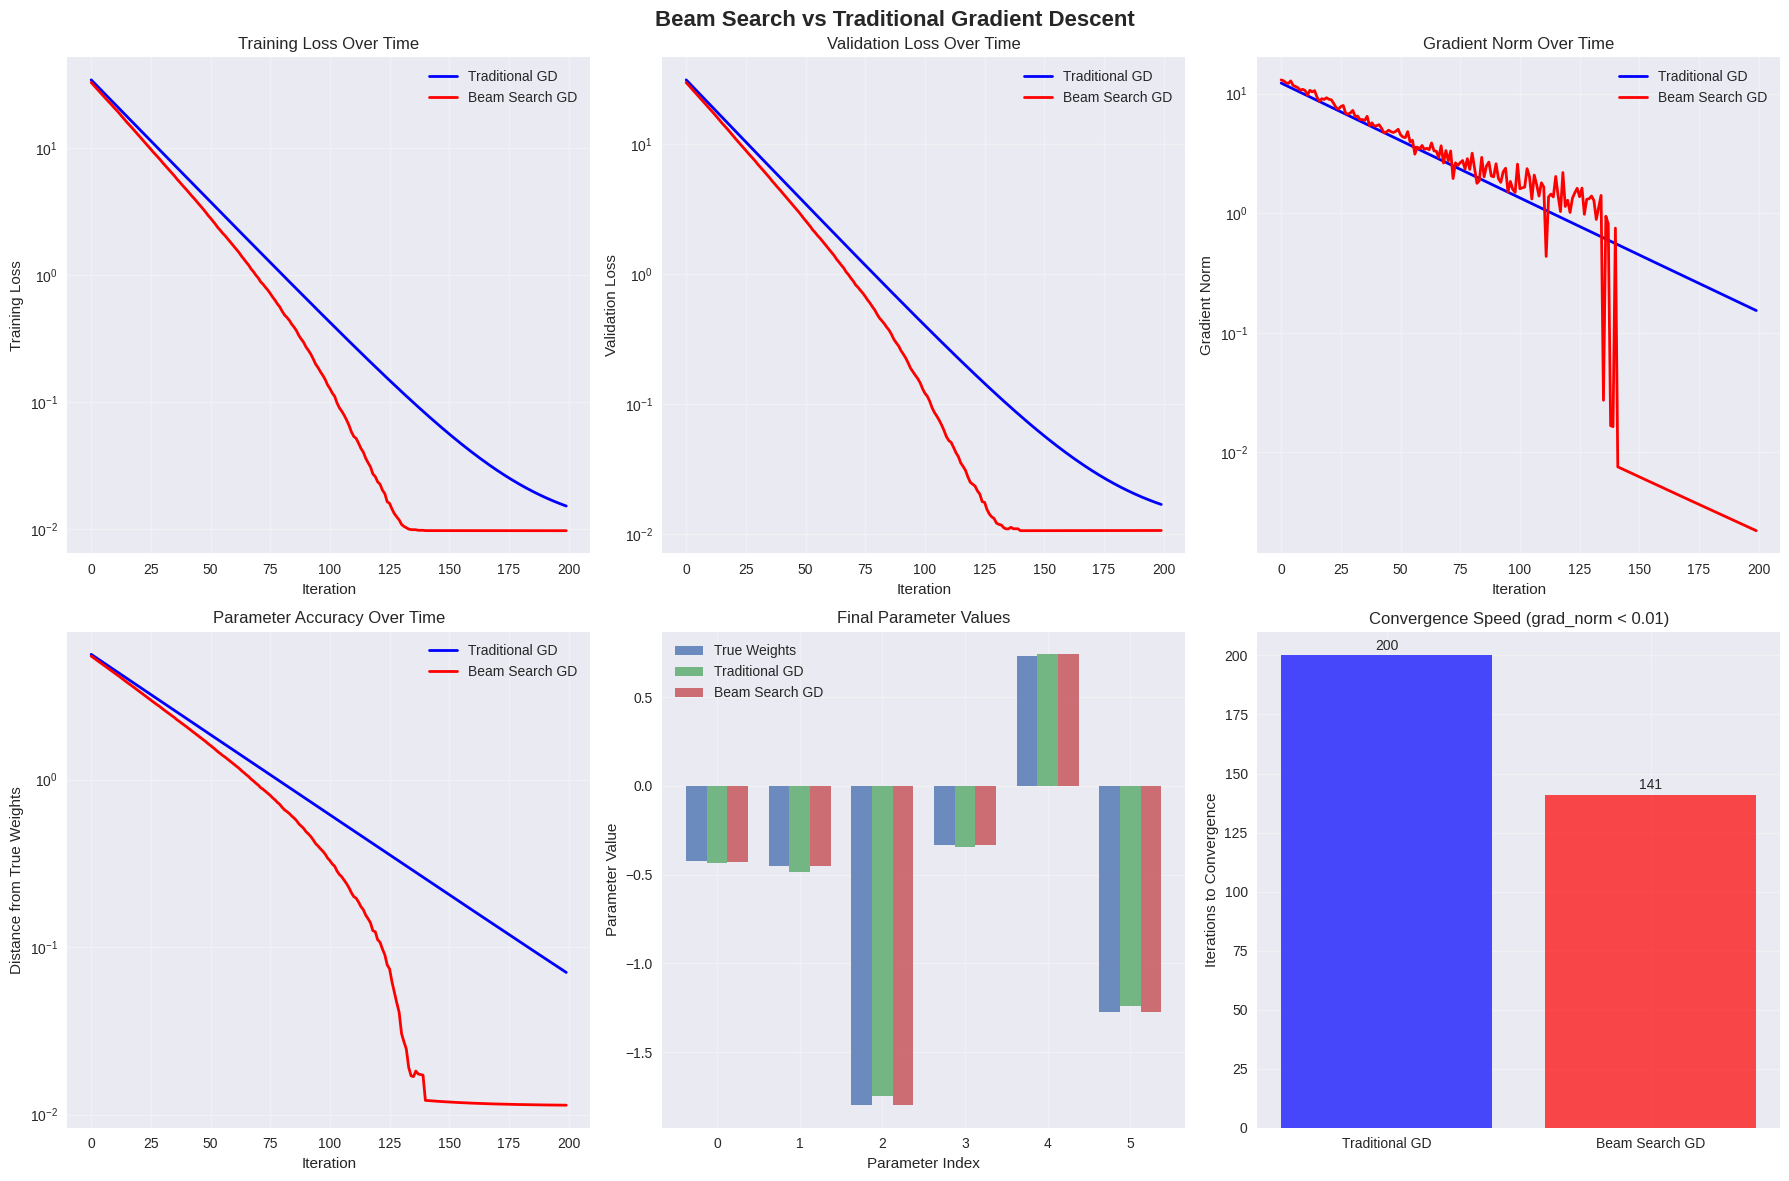

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
np.random.seed(42)

class BeamGradientDescent:
    def __init__(self, beam_width=3, learning_rate=0.01, max_iters=200, noise_scale=0.5):
        self.beam_width = beam_width
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.noise_scale = noise_scale
        self.history = []

    def fit(self, loss_fn, grad_fn, start_point, validation_fn=None):
        """Beam search gradient descent"""
        self.history = []

        # Initialize beams - each beam is a point in parameter space
        beams = [{'params': np.array(start_point), 'loss': loss_fn(start_point)}]

        for iteration in range(self.max_iters):
            candidates = []

            # For each current beam, generate multiple candidate next steps
            for beam in beams:
                grad = grad_fn(beam['params'])

                # Generate candidate directions
                for i in range(self.beam_width * 2):  # Generate more candidates than beam width
                    if i == 0:
                        # Always include the true gradient direction
                        candidate_grad = grad
                    else:
                        # Add noise to create alternative directions
                        noise = np.random.normal(0, self.noise_scale, size=grad.shape)
                        candidate_grad = grad + noise

                    # Take a step in this direction
                    new_params = beam['params'] - self.learning_rate * candidate_grad
                    new_loss = loss_fn(new_params)

                    candidates.append({
                        'params': new_params,
                        'loss': new_loss,
                        'grad': candidate_grad,
                        'parent_beam': beam
                    })

            # Select top beam_width candidates based on lowest loss
            candidates.sort(key=lambda x: x['loss'])
            beams = candidates[:self.beam_width]

            # Track the best beam
            best_beam = beams[0]
            val_loss = validation_fn(best_beam['params']) if validation_fn else None

            self.history.append({
                'iteration': iteration,
                'params': best_beam['params'].copy(),
                'train_loss': best_beam['loss'],
                'val_loss': val_loss,
                'grad_norm': np.linalg.norm(best_beam['grad']),
                'all_beams': [b['params'].copy() for b in beams]
            })

            # Early stopping
            if np.linalg.norm(best_beam['grad']) < 1e-6:
                break

        return self

class TraditionalGradientDescent:
    def __init__(self, learning_rate=0.01, max_iters=200):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.history = []

    def fit(self, loss_fn, grad_fn, start_point, validation_fn=None):
        """Traditional gradient descent"""
        self.history = []
        params = np.array(start_point)

        for iteration in range(self.max_iters):
            loss = loss_fn(params)
            grad = grad_fn(params)
            val_loss = validation_fn(params) if validation_fn else None

            self.history.append({
                'iteration': iteration,
                'params': params.copy(),
                'train_loss': loss,
                'val_loss': val_loss,
                'grad_norm': np.linalg.norm(grad)
            })

            # Update parameters
            params = params - self.learning_rate * grad

            # Early stopping
            if np.linalg.norm(grad) < 1e-6:
                break

        return self

def generate_regression_data(n_samples=1000, n_features=5, noise=0.1):
    """Generate synthetic regression data with train/validation split"""
    X = np.random.randn(n_samples, n_features)
    true_weights = np.random.randn(n_features + 1)  # +1 for bias

    # Add bias column
    X_with_bias = np.column_stack([np.ones(n_samples), X])
    y = X_with_bias @ true_weights + noise * np.random.randn(n_samples)

    # Split into train/validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_with_bias, y, test_size=0.3, random_state=42
    )

    return X_train, X_val, y_train, y_val, true_weights

def create_loss_functions(X_train, y_train, X_val, y_val):
    """Create loss and gradient functions for linear regression"""

    def train_loss(weights):
        pred = X_train @ weights
        mse = np.mean((y_train - pred) ** 2)
        return mse

    def train_grad(weights):
        pred = X_train @ weights
        grad = -2 * X_train.T @ (y_train - pred) / len(y_train)
        return grad

    def val_loss(weights):
        pred = X_val @ weights
        mse = np.mean((y_val - pred) ** 2)
        return mse

    return train_loss, train_grad, val_loss

def plot_comparison(traditional_gd, beam_gd, true_weights):
    """Create comprehensive comparison plots"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Beam Search vs Traditional Gradient Descent', fontsize=16, fontweight='bold')

    # Extract histories
    trad_history = traditional_gd.history
    beam_history = beam_gd.history

    iterations_trad = [h['iteration'] for h in trad_history]
    iterations_beam = [h['iteration'] for h in beam_history]

    # 1. Training Loss
    axes[0,0].plot(iterations_trad, [h['train_loss'] for h in trad_history],
                   'b-', label='Traditional GD', linewidth=2)
    axes[0,0].plot(iterations_beam, [h['train_loss'] for h in beam_history],
                   'r-', label='Beam Search GD', linewidth=2)
    axes[0,0].set_xlabel('Iteration')
    axes[0,0].set_ylabel('Training Loss')
    axes[0,0].set_title('Training Loss Over Time')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].set_yscale('log')

    # 2. Validation Loss
    axes[0,1].plot(iterations_trad, [h['val_loss'] for h in trad_history],
                   'b-', label='Traditional GD', linewidth=2)
    axes[0,1].plot(iterations_beam, [h['val_loss'] for h in beam_history],
                   'r-', label='Beam Search GD', linewidth=2)
    axes[0,1].set_xlabel('Iteration')
    axes[0,1].set_ylabel('Validation Loss')
    axes[0,1].set_title('Validation Loss Over Time')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].set_yscale('log')

    # 3. Gradient Norm
    axes[0,2].plot(iterations_trad, [h['grad_norm'] for h in trad_history],
                   'b-', label='Traditional GD', linewidth=2)
    axes[0,2].plot(iterations_beam, [h['grad_norm'] for h in beam_history],
                   'r-', label='Beam Search GD', linewidth=2)
    axes[0,2].set_xlabel('Iteration')
    axes[0,2].set_ylabel('Gradient Norm')
    axes[0,2].set_title('Gradient Norm Over Time')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)
    axes[0,2].set_yscale('log')

    # 4. Parameter Distance from True Values
    trad_distances = [np.linalg.norm(h['params'] - true_weights) for h in trad_history]
    beam_distances = [np.linalg.norm(h['params'] - true_weights) for h in beam_history]

    axes[1,0].plot(iterations_trad, trad_distances, 'b-', label='Traditional GD', linewidth=2)
    axes[1,0].plot(iterations_beam, beam_distances, 'r-', label='Beam Search GD', linewidth=2)
    axes[1,0].set_xlabel('Iteration')
    axes[1,0].set_ylabel('Distance from True Weights')
    axes[1,0].set_title('Parameter Accuracy Over Time')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].set_yscale('log')

    # 5. Final Parameter Comparison
    final_trad = trad_history[-1]['params']
    final_beam = beam_history[-1]['params']

    x_pos = np.arange(len(true_weights))
    width = 0.25

    axes[1,1].bar(x_pos - width, true_weights, width, label='True Weights', alpha=0.8)
    axes[1,1].bar(x_pos, final_trad, width, label='Traditional GD', alpha=0.8)
    axes[1,1].bar(x_pos + width, final_beam, width, label='Beam Search GD', alpha=0.8)
    axes[1,1].set_xlabel('Parameter Index')
    axes[1,1].set_ylabel('Parameter Value')
    axes[1,1].set_title('Final Parameter Values')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    # 6. Convergence Rate Comparison
    conv_threshold = 0.01  # Define convergence as when gradient norm < this

    trad_conv_iter = next((i for i, h in enumerate(trad_history)
                          if h['grad_norm'] < conv_threshold), len(trad_history))
    beam_conv_iter = next((i for i, h in enumerate(beam_history)
                          if h['grad_norm'] < conv_threshold), len(beam_history))

    methods = ['Traditional GD', 'Beam Search GD']
    conv_iters = [trad_conv_iter, beam_conv_iter]
    colors = ['blue', 'red']

    bars = axes[1,2].bar(methods, conv_iters, color=colors, alpha=0.7)
    axes[1,2].set_ylabel('Iterations to Convergence')
    axes[1,2].set_title(f'Convergence Speed (grad_norm < {conv_threshold})')
    axes[1,2].grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, value in zip(bars, conv_iters):
        axes[1,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                      str(value), ha='center', va='bottom')

    plt.tight_layout()
    return fig

def print_results_summary(traditional_gd, beam_gd, true_weights):
    """Print numerical comparison results"""
    trad_final = traditional_gd.history[-1]
    beam_final = beam_gd.history[-1]

    print("="*60)
    print("GRADIENT DESCENT COMPARISON RESULTS")
    print("="*60)

    print(f"\n📊 FINAL METRICS:")
    print(f"{'Metric':<25} {'Traditional GD':<15} {'Beam Search GD':<15} {'Winner':<10}")
    print("-" * 70)

    # Training Loss
    trad_loss = trad_final['train_loss']
    beam_loss = beam_final['train_loss']
    loss_winner = "Beam" if beam_loss < trad_loss else "Traditional"
    print(f"{'Training Loss':<25} {trad_loss:<15.6f} {beam_loss:<15.6f} {loss_winner:<10}")

    # Validation Loss
    trad_val = trad_final['val_loss']
    beam_val = beam_final['val_loss']
    val_winner = "Beam" if beam_val < trad_val else "Traditional"
    print(f"{'Validation Loss':<25} {trad_val:<15.6f} {beam_val:<15.6f} {val_winner:<10}")

    # Parameter Accuracy
    trad_dist = np.linalg.norm(trad_final['params'] - true_weights)
    beam_dist = np.linalg.norm(beam_final['params'] - true_weights)
    dist_winner = "Beam" if beam_dist < trad_dist else "Traditional"
    print(f"{'Param Distance':<25} {trad_dist:<15.6f} {beam_dist:<15.6f} {dist_winner:<10}")

    # Convergence Speed
    trad_iters = len(traditional_gd.history)
    beam_iters = len(beam_gd.history)
    iter_winner = "Beam" if beam_iters < trad_iters else "Traditional"
    print(f"{'Iterations':<25} {trad_iters:<15} {beam_iters:<15} {iter_winner:<10}")

    print(f"\n🎯 PARAMETER RECOVERY:")
    print(f"True weights:        {true_weights}")
    print(f"Traditional final:   {trad_final['params']}")
    print(f"Beam search final:   {beam_final['params']}")

    print(f"\n🚀 IMPROVEMENT SUMMARY:")
    loss_improvement = (trad_loss - beam_loss) / trad_loss * 100
    val_improvement = (trad_val - beam_val) / trad_val * 100

    print(f"Training loss improvement: {loss_improvement:+.2f}%")
    print(f"Validation loss improvement: {val_improvement:+.2f}%")
    print(f"Parameter accuracy improvement: {(trad_dist - beam_dist)/trad_dist*100:+.2f}%")

def main():
    # Generate data
    print("🔄 Generating synthetic regression data...")
    X_train, X_val, y_train, y_val, true_weights = generate_regression_data(
        n_samples=1000, n_features=5, noise=0.1
    )

    # Create loss functions
    train_loss_fn, train_grad_fn, val_loss_fn = create_loss_functions(
        X_train, y_train, X_val, y_val
    )

    # Initialize optimizers
    print("🚀 Running optimization experiments...")
    traditional_gd = TraditionalGradientDescent(learning_rate=0.01, max_iters=200)
    beam_gd = BeamGradientDescent(beam_width=3, learning_rate=0.01, max_iters=200, noise_scale=0.5)

    # Random starting point
    start_point = np.random.randn(len(true_weights)) * 2

    # Run optimizations
    print("   Traditional Gradient Descent...")
    traditional_gd.fit(train_loss_fn, train_grad_fn, start_point, val_loss_fn)

    print("   Beam Search Gradient Descent...")
    beam_gd.fit(train_loss_fn, train_grad_fn, start_point, val_loss_fn)

    # Print results
    print_results_summary(traditional_gd, beam_gd, true_weights)

    # Create plots
    print("\n📈 Creating comparison plots...")
    fig = plot_comparison(traditional_gd, beam_gd, true_weights)
    plt.show()

    return traditional_gd, beam_gd, true_weights

if __name__ == "__main__":
    traditional_gd, beam_gd, true_weights = main()